In [2]:
from scipy.integrate import odeint, romberg, quad
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [3]:
# plasma parameters

#we need
plasma_params = {'n_i': 1e16, 'T_e': 1, 'T_i': 1, 'm_i': 1}

## Calculate plasma parameters

Zimmermann's model is described by the the the system of ODEs

$$
\begin{eqnarray}
\frac{\partial V_x}{\partial x} &=& \frac{\omega \tau \cos(\alpha) V_x V_z + \Delta +V_x^2}{1-V_x^2} \\
\frac{\partial V_y}{\partial x} &=& \frac{\omega \tau \sin (\alpha) V_z - V_y}{V_x} \\
\frac{\partial V_z}{\partial x} &=& \omega \tau \cos(\alpha) - \omega \tau \sin (\alpha) V_y/V_x - V_z/V_x \\
\frac{\partial \phi}{\partial x} &=& \frac{1}{V_x} \frac{\partial V_x}{\partial x} - \frac{\Delta}{V_x}
\end{eqnarray}
$$

In [4]:
def zimmerman_func(x, t, params):
    
    result = np.zeros(x.shape)
    
    omega = params['omega']
    alpha = params['alpha']
    tau = params['tau']
    delta = params['delta']
    
    omega_tau = omega*tau
    
    #setting up v_x derivative
    result[0] = (omega_tau *np.cos(alpha) *x[0] *x[2] +delta +x[0]**2)/(1-x[0]**2)
    
    #v_y derivative
    result[1] = (omega_tau *np.sin(alpha) *x[2] -x[1])/x[0]
    
    #v_Z derivative
    result[2] = omega_tau *np.cos(alpha) - omega_tau *np.sin(alpha) *x[1]/x[0] - x[2]/x[0]
    
    #potential derivative
    result[3] = (result[0] - delta)/x[0]
    
    return result

In [5]:
def odeint_zimmerman(zimmerman_func, y0, params, dx=1e-5):
    
    y = y0
    x = 0
    
    result = []
    x_space = []
    
    while y[0] < 1:
        #print(y)
        result.append(y)
        x_space.append(x)
        y = y + dx *zimmerman_func(y, 0, params)
        x = x + dx     
    
    return np.array(result), np.array(x_space)

In [6]:
params = {'omega': 1, 'alpha': 20 *np.pi/180, 'tau':1e1, 'delta': 1}

y0 = np.array([1e-6, 0, 0, 0])

soln, x = odeint_zimmerman(zimmerman_func, y0, params, dx=1e-6)

## Before proceeding we'll try to work with ode object in 

In [31]:
from scipy.integrate import ode


def zimmerman_func_i(t, x, params):
    
    result = np.zeros(x.shape)
    
    omega = params['omega']
    alpha = params['alpha']
    tau = params['tau']
    delta = params['delta']
    
    omega_tau = omega*tau
    
    #setting up v_x derivative
    result[0] = (omega_tau *np.cos(alpha) *x[0] *x[2] +delta +x[0]**2)/(1-x[0]**2)
    
    #v_y derivative
    result[1] = (omega_tau *np.sin(alpha) *x[2] -x[1])/x[0]
    
    #v_Z derivative
    result[2] = omega_tau *np.cos(alpha) - omega_tau *np.sin(alpha) *x[1]/x[0] - x[2]/x[0]
    
    #potential derivative
    #result[3] = (result[0])/x[0]
    result[3] = (result[0] - delta)/x[0]
    
    return result

In [40]:
def dynamic_stepping(y, y_prev, dx0, dx_min = 1e-7, dx_max=10, dy=5e-4):
    grad = np.abs(y[0] - y_prev[0])/dx0
    dx = dy/grad
    
    if dx < dx_min:
        dx = dx_min
    elif dx > dx_max:
        dx = dx_max
        
    dx = np.sqrt(dx0 *dx)
        
    return dx

In [41]:
def zimmerman_solve(func, params, y0 = np.array([1e-3, 1e-3, 1e-3, 1e-3]), x0=0, vx_max=1, dx=1e-3, nsteps=10000):
    
    integrator = ode(func).set_integrator('dop853', nsteps=nsteps)
    integrator.set_initial_value(y0, x0).set_f_params(params)
    
    x = [x0]
    y = [y0]
    
    soln = y0
    
#     grad = []

    steps = []
    
    
    while integrator.successful() and soln[0] <= vx_max:
        
        time = integrator.t+dx
        
        soln = integrator.integrate(time)

        x.append(time)
        y.append(soln)
        
        steps.append(dx)
        
        dx = dynamic_stepping(y[-1], y[-2], dx)
        
        #print(y[-1], y[-2])
        
#         grad_val = np.abs(y[-1][0] - y[-2][0]) /np.abs(y[-1][0])
#         grad.append(grad_val)
        
        #print(x, soln, integrator.t, integrator.successful())
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y, steps

/usr/lib64/python3.4/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dop853: larger nmax is needed
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


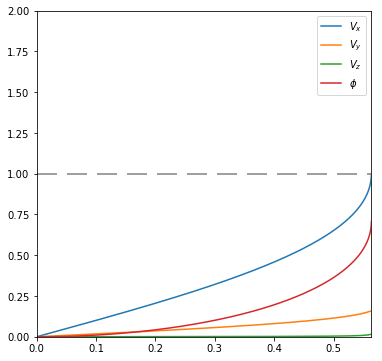

In [66]:
params = {'omega': 1, 'alpha': 80 *np.pi/180, 'tau': 100, 'delta': 1}
#params = {'omega': 1, 'alpha': 20 *np.pi/180, 'tau':1, 'delta': 10}

#y0 = np.array([1e-2, 1e-2, 1e-2, 1e-2])
y0 = np.array([1e-6, 1e-6, 1e-6, 1e-6])

x, y, steps = zimmerman_solve(zimmerman_func_i, params, dx=1e-6, y0=y0)

fig, ax = plt.subplots(figsize=(6,6))

# plt.semilogx(x, y[:,0], label=r'$V_x$')
# plt.semilogx(x, y[:,1], label=r'$V_y$')
# plt.semilogx(x, y[:,2], label=r'$V_z$')
# plt.semilogx(x, y[:,3], label=r'$\phi$')

plt.plot(x, y[:,0], label=r'$V_x$')
plt.plot(x, y[:,1], label=r'$V_y$')
plt.plot(x, y[:,2], label=r'$V_z$')
plt.plot(x, y[:,3], label=r'$\phi$')
plt.ylim(0, 2)

plt.plot([0, 100], [1, 1], color='gray', dashes=[10, 5])
plt.xlim(0, max(x))

plt.legend()

1963


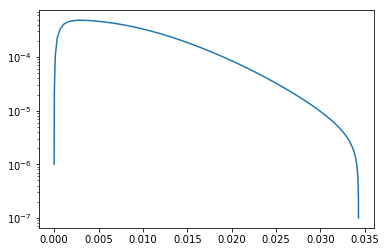

In [64]:
print(len(steps))
plt.semilogy(np.cumsum(steps), steps)

In [12]:
np.cumsum(steps)

array([  1.00000000e-04,   3.23584214e-04,   6.57902614e-04, ...,
         5.60783821e-01,   5.60793821e-01,   5.60803821e-01])

In [13]:
len(steps)

1955

## Conversion to physical parameters

### Coloumb logarithm

$$
\log \Lambda = \log \left( \frac{4 \pi \lambda_D}{\lambda_{qm}} \right)
$$


In [14]:
def reduced_mass(mass_a, mass_b):
    '''
    Return reduced mass
    --------------------
    
    params:
    mass_a - float, mass 1
    mass_b - float, mass 2
    '''
    
    return mass_a *mass_b/(mass_a + mass_b)


In [15]:
def quantum_length(params):
    '''
    Return quantum length mass
    --------------------
    
    params:
    params - dictionary, plasma parameters
    '''
        
    debye_length = params['debye_length']
    
    T_e = params['T_e']
    T_i = params['T_i']
    
    m_i_amu = params['m_i']
    m_i = m_i_amu*1e-3/const.N_A
    
    reduced_mass_ii = reduced_mass(m_i, m_i)
    
    quantum_length = const.h/np.sqrt(3*T_i *reduced_mass_ii *const.e)
    
    return quantum_length


In [16]:
def coulomb_log_precise(params, mach_number=1, nsteps = 500):
    
    debye_length = params['debye_length']
    
    T_e = params['T_e']
    T_i = params['T_i']
    
    m_i_amu = params['m_i']
    m_i = m_i_amu*1e-3/const.N_A
    
    reduced_mass_ii = reduced_mass(m_i, m_i)
    
    quantum_length_ii = const.h/np.sqrt(3*T_i *reduced_mass_ii *const.e)
    
    length_ratio = quantum_length_ii/4 /np.pi /debye_length
    
    integrand = lambda x, scale: 0.5 *x/(scale**2 + x)**2
    
    result = integrate.quad(integrand, 0, mach_number, args=(length_ratio,), limit=nsteps)
    
    return result

In [17]:
def coulomb_log_approx(params):
    
    result = np.log(4 *np.pi *debye_length/quantum_length_ii)    

In [18]:
params = {'omega': 1, 'alpha': 20 *np.pi/180, 'tau':1e-2, 'delta': 0, 'T_e': 10, 'T_i': 10, 'n_e': 1e20, 
          'B': np.array([1, 0, 0]), 'm_i': 50}

import scipy.constants as const

T_e = params['T_e']
T_i = params['T_e']

n_e = params['n_e']
n_i = n_e
m_i_amu = params['m_i']
m_i = m_i_amu*1e-3/const.N_A
m_i2 = 2*1e-3/const.N_A


def reduced_mass(mass_a, mass_b):
    return mass_a *mass_b/(mass_a + mass_b)

debye_length = np.sqrt(const.epsilon_0 /const.e /(n_e/T_e))
debye_length = np.sqrt(const.epsilon_0 /const.e /(n_e/T_e + n_i/T_i))
reduced_mass_ii = reduced_mass(m_i, m_i2)
quantum_length_ii = const.h/np.sqrt(3*T_i *reduced_mass_ii *const.e)

coulomb_log_ii = np.log(4 *np.pi *debye_length/quantum_length_ii)

print("ql = {0:.3e}, dl = {1:.3e}".format(quantum_length_ii, debye_length))
coulomb_log_ii

ql = 5.348e-12, dl = 1.662e-06


15.177942581708924

In [19]:
def func_c(x, scale):
    return 0.5 *x/(scale**2 + x)**2

In [20]:
from scipy import integrate

In [21]:
scale = quantum_length_ii/4 /np.pi /debye_length

coulomb_log_ii_precise = integrate.quad(func_c, 0, 1, args=(scale,), limit=400)
coulomb_log_ii_precise

(14.677942581708988, 1.5244440152444472e-08)

In [22]:
def couloumb_log_approx(n_e, T_e):
    return 17.3-0.5*np.log(n_e/1e20) + 1.5 *np.log(T_e/1e3)

In [23]:
couloumb_log_approx(n_e, T_i)

10.392244721017864

In [24]:
const.k/const.e

8.617330337217213e-05